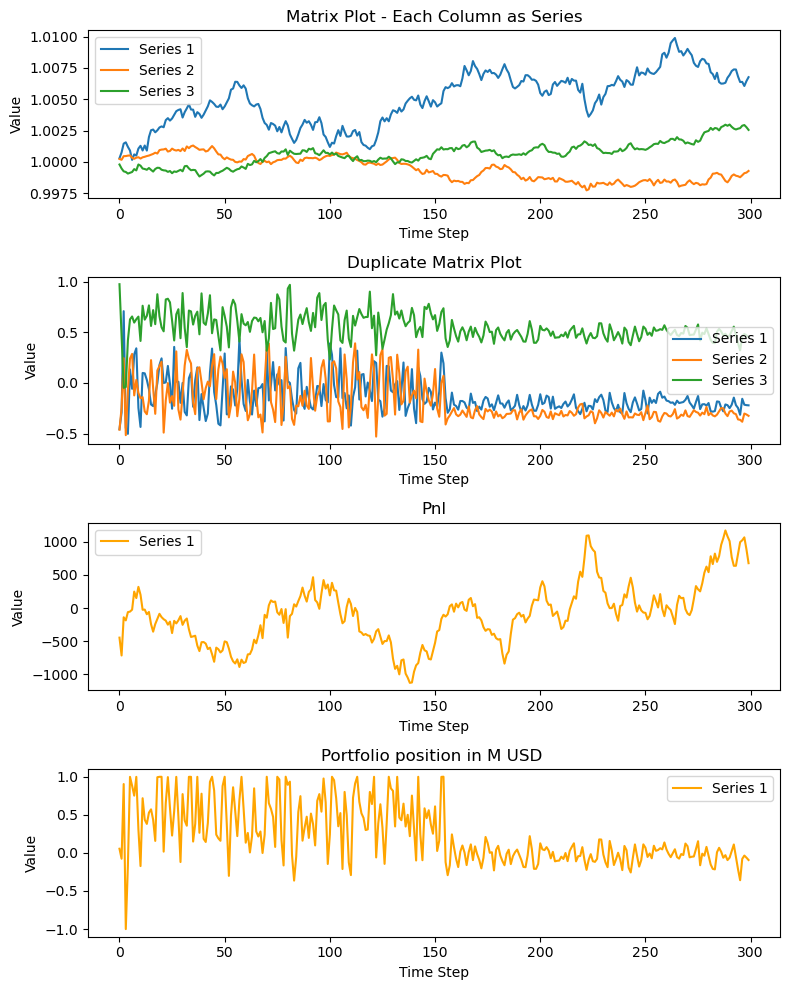

In [ ]:
import numpy as np
import math
import random

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Project made by Léa Beudin using Chat gpt  
# The project simulates the fx portfolio and the rebalancing optimiwing pnl 
# the portfolio rebalance strategy is using a biological algo particle swarm optimization  
# - Trend following methodology using 2 exponantial moving average 
# 
# todo léa  improve this algo insert mean reverting trading strategies 
# todo léa  improve it should be extended to inlcude cost and a backtest with large stochastic simulation
# todo léa  isnert more fx - and different calibration for the fx simulations
# todo insert an algo to determine the parameters of the fx symbol like nelder mead
# todo insert a statistical class including the hurst exponant

class Particle:
    def __init__(self, dimensions, bounds, params, index):
        self.position = np.random.uniform(bounds[0], bounds[1], dimensions)  
        self.velocity = np.random.uniform(-1, 1, dimensions)  
        self.pbest_position = self.position  
        self.pbest = float('inf')  
        self.params = params
        self.value = 1
        self.index = index
        self.last_return = 0
        self.last_positions = []
        self.immediate_return = 0



    def update_personal_best(self, minimize_function,last_returns, last_positions):
        current = minimize_function(self, last_returns, last_positions)
        self.last_positions = last_positions
        if current < self.pbest:
            self.pbest = current
            self.pbest_position = self.position.copy()

        
        val = simulate_Merton_Jump(self.value, self.params)

        #transform into logs
        self.immediate_return = 1- self.value/val

        #calculate weight
        weight = math.exp(alpha * dt)

        #calculate average
        self.last_return = self.immediate_return * weight +  self.last_return * (1-weight)
 
        self.value = val

    moving_averages = []



class PSO:
    def __init__(self, n_particles, dimensions, paramss, bounds, w=0.5, c1=1.5, c2=1.5, n_iterations=100):
        self.n_particles = n_particles
        self.dimensions = dimensions
        self.bounds = bounds
        self.w = w  # Inertia weight
        self.c1 = c1  # Cognitive coefficient
        self.c2 = c2  # Social coefficient
        self.n_iterations = n_iterations
        self.swarm = [Particle(dimensions, bounds, paramss[i], i ) for i in range(n_particles)] 
        #self.gbest_position = np.random.uniform(bounds[0], bounds[1], dimensions)  # Global best position
        self.gbest_value = float('inf')  # Global best value (initialized to infinity)
        self.last_return =  [0 for i in range(n_particles)]
        self.last_position =  [1/n_particles for i in range(n_particles)]
        self.portfolio_history = []
        self.portfolio_value = 0
        self.position_history = []
        #self.gbest_value = [1 for i in range(n_particles)] 
        self.gbest_position  = [np.random.uniform(bounds[0], bounds[1], dimensions)for i in range(n_particles)] 
        self.slow_ema = 0
        self.fast_ema = 0
        self.pnl_cummu  = 0
        self.pnl = []
        self.value_history = []



    def optimize(self, objective_function):
        for iteration in range(self.n_iterations):
            temp = []
            temp_pos = []
            temp_val = []

            for particle in self.swarm:
                # Update the personal best of each particle
                particle.update_personal_best(objective_function, self.last_return, self.last_position)
                temp_pos.append(particle.position[0])
                temp.append(particle.last_return)
                temp_val.append(particle.value)
            self.last_return = temp
            self.last_position = temp_pos

            self.value_history.append(temp_val)
            self.position_history.append(temp_pos)


            self.portfolio_chock()

            total = 0
            i = 0
            for particle in self.swarm:

                if particle.pbest< self.gbest_value :
                    self.gbest_value = particle.pbest
                    self.gbest_position = particle.last_positions.copy()

                # Update velocity and position
                r1, r2 = np.random.random(self.dimensions), np.random.random(self.dimensions)
                cognitive_velocity = self.c1 * r1 * (particle.pbest_position - particle.position)
                social_velocity = self.c2 * r2 * (self.gbest_position[i] - particle.position)
                particle.velocity = self.w * particle.velocity + cognitive_velocity + social_velocity

                # Update position and apply bounds
                #todo lea block to sum = 1
                particle.position += particle.velocity
                total += abs(particle.position)
                i = i + 1
                #particle.position = np.clip(particle.position, self.bounds[0], self.bounds[1])
            for particle in self.swarm:
                 particle.position = particle.position/total

            self.portfolio_history.append(self.portfolio_value)
        return [particle.position for particle in self.swarm]
    

    def portfolio_chock(self):
            #change this also to incorporate mean reverting 
            val = sum( [particule.position * particule.value for particule in self.swarm])
            delta_revenue =  sum( [particule.immediate_return * particule.position / particule.value for particule in self.swarm])

            pnl_change =  delta_revenue/self.pnl_cummu  if self.pnl_cummu !=0 else 0

            self.pnl.append(delta_revenue)
            self.pnl_cummu = self.pnl_cummu + delta_revenue

            self.portfolio_value = val
            #calculate weight
            fast_weight = math.exp(alpha * dt)
            slow_weight = math.exp(alpha2 * dt)

            self.fast_ema = pnl_change * fast_weight +  self.fast_ema * (1-fast_weight)
            self.slow_ema =  pnl_change * slow_weight +  self.fast_ema * (1-slow_weight)

            if self.fast_ema <self.fast_ema- 0.05:
                #todo do position chock 
                for particle in self.swarm: 
                    particle.pbest = float('inf')  
                    #todo léa to improve the algo - change the np random probability to match the drift of the observed currencies
                    particle.position = particle.position+np.random.random(self.dimensions)
                self.gbest_value= 1




def simulate_Merton_Jump(S, params) :
    mu, sigma, lamb, nu, delta = params
    dt = 0.01 
    dW = math.sqrt(dt) * gaussian()
    diffusion = (mu - 0.5 * sigma ** 2) * dt + sigma * dW

    dN = 1 if random.random() < lamb * dt  else 0
    J = math.exp(nu + delta * gaussian()) if dN == 1 else  1

    return S * math.exp(diffusion) * J
		
def gaussian() :
    u = random.random()
    v = random.random()
    return math.sqrt(-2 * math.log(u)) * math.cos(2 * math.pi * v)
    

def minimize_function(x, value_before,  position):
    temp = 0
    for i in range(len(value_before)):
        if x.index == i :
            temp = temp + x.last_return * x.position
        else :
            temp = temp + value_before[i]*position[i]
    #max of the imidiate return + portfolio 
    return max(max(value_before), abs(min(value_before)))- temp



# Parameters and assumption made
n_particles = 3 # nb of particles
dimensions = 1  # nb of dimensions (e.g., x and y)
bounds = (-1, 1)  # Bounds for each dimension
n_iterations = 300  # iterations
S = 1 # Initial FX rate
alpha = -math.log(2)/0.006
alpha2 = -math.log(2)/0.003
dt = 0.01 
# we simulate prices starting at 1, we consider we used only USDXXX

paramss = [[0,0.004,0.1,0.0003,0.1],[0.0001,0.0015,0.05,0.001,0.1],[0.0002,0.0015,0.02,0.0005,0.1]]


# Initialize PSO and optimize
pso = PSO(n_particles, dimensions, paramss, bounds, n_iterations=n_iterations)
best_position = pso.optimize(minimize_function)


# Transpose matrix to separate each series as a list
pso_value = np.array(pso.value_history)  
pso_position = np.array(pso.position_history)  
pso_port = np.array(pso.portfolio_history)  
pso_pnl = np.array(pso.pnl).cumsum() *1e6
series_count = pso_value.shape[1]

fig, axs = plt.subplots(4, 1, figsize=(8, 10))

for i in range(series_count):
    axs[0].plot(pso_value[:,i], label=f"Series {i+1}")
    axs[1].plot(pso_position[:,i], label=f"Series {i+1}")


#value of the assets
axs[0].set_title("Matrix Plot - Each Column as Series")
axs[0].legend()
axs[0].set_xlabel("Time Step")
axs[0].set_ylabel("Value")

# Second Plot: position 
axs[1].set_title("Duplicate Matrix Plot")
axs[1].legend()
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Value")
# generated Pnl 
axs[2].plot(pso_pnl, label=f"Series {1}",color="orange")
axs[2].set_title("Pnl")
axs[2].legend()
axs[2].set_xlabel("Time Step")
axs[2].set_ylabel("Value")

# Fourth Plot: the exposition is USD
axs[3].plot(pso_port, label=f"Series {1}", color="orange")
axs[3].set_title("Portfolio position in M USD ")
axs[3].legend()
axs[3].set_xlabel("Time Step")
axs[3].set_ylabel("Value")

plt.tight_layout()
plt.show()
